# 1 线性回归
线性模型、损失函数、解析解、随机梯度下降、预测

## 1.1 矢量化加速


In [14]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

#计时器
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [15]:
n = 10000
a = torch.ones([n])
b = torch.ones([n])

# 第一种方法，使用for循环
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
print(f'{timer.stop():.5f} sec')

# 第二种方法
timer.start()
d = a + b
print(f'{timer.stop():.5f} sec')

0.20402 sec
0.00000 sec


## 1.2 正态分布与平方损失

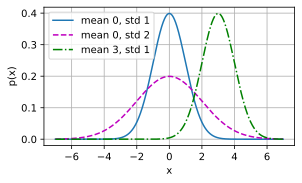

In [16]:
# 定义一个正态分布函数
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)
# 可视化正态分布
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

## 1.3 从线性回归到深度网络
线性回归是一个单层神经网络

## 1.4 优化算法
梯度下降：通过不断沿着反梯度方向更新参数求解，超参数学习率的选取

小批量随机梯度下降，批量的选取


## 1.5 练习
1.假设有一组数据，找到一个常数b， 使得最小化$\sum(x_i-b)^2$

最优值b的解析解是均值，展开推导可得

2.推导出使用平方误差的线性回归优化问题的解析解

XW=Y

目标函数 argmin(0.5(y-XW)^2)

解析解$W=(X^TX)^{-1}X^Ty$

3.假设控制附加噪声ε的噪声模型是指数分布p(ε)=0.5exp(-|ε|)

模型-logP(y|X)下数据的负对数似然/解析解



# 2 从零开始实现
## 2.1生成数据集

In [17]:
import torch
from d2l import torch as d2l

In [18]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    # 均值为0，方差为1 的随机数
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
true_w,true_b,features,labels

(tensor([ 2.0000, -3.4000]),
 4.2,
 tensor([[-0.7865,  0.5585],
         [-2.0505, -1.2967],
         [ 0.0764,  1.1661],
         ...,
         [ 0.0771,  0.4217],
         [ 0.0405, -0.3050],
         [-0.6575, -1.1441]]),
 tensor([[ 7.1292e-01],
         [ 4.5221e+00],
         [ 3.8364e-01],
         [ 4.6832e+00],
         [ 6.2914e-01],
         [ 1.1268e+00],
         [ 9.9083e+00],
         [ 5.6621e+00],
         [ 6.8142e+00],
         [ 4.2350e+00],
         [ 3.0071e+00],
         [ 6.6275e+00],
         [ 9.1041e+00],
         [-5.9199e+00],
         [-2.1661e-01],
         [ 4.3134e+00],
         [ 7.1271e+00],
         [-8.8075e-01],
         [ 2.0256e+00],
         [ 7.7254e+00],
         [-1.5193e+00],
         [ 7.8468e+00],
         [ 2.8035e+00],
         [-4.2638e+00],
         [ 1.2297e+00],
         [ 7.9015e+00],
         [-2.3339e+00],
         [ 4.8401e-01],
         [ 1.5061e+00],
         [ 4.2885e+00],
         [ 2.5810e+00],
         [ 2.5573e+00],
       

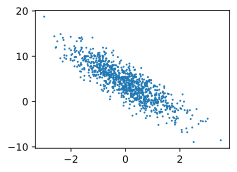

In [19]:
# 查看第二个特征和标签的散点图，查看二者的线性关系
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

## 2.2 读取数据集
定义一个函数能打乱数据集中的样本并以小批量方式获取数据。

In [20]:
# 定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量。 每个小批量包含一组特征和标签。
import random
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # 生成每个样本的index
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序，打乱顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        
batch_size = 10

'''for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break'''

"for X, y in data_iter(batch_size, features, labels):\n    print(X, '\n', y)\n    break"

## 2.3 初始化模型参数

In [21]:
# 将模型初始化均值为0，方差为0.01的参数，偏差为0
w = torch.normal(0, 0.00, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## 2.4 定义模型

In [22]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    print(X.size,w.size,b.size)
    return torch.matmul(X, w) + b

## 2.5 定义损失函数

In [23]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2 # 这里没有求和

## 2.6 定义优化算法

In [24]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    # 更新的时候不参与梯度计算
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 2.7 训练

In [25]:
lr = 0.05
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        #print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

<built-in method size of Tensor object at 0x0000022BAC9C9310> <built-in method size of Tensor object at 0x0000022BABD77F40> <built-in method size of Tensor object at 0x0000022BAD513B30>
<built-in method size of Tensor object at 0x0000022BAC2065E0> <built-in method size of Tensor object at 0x0000022BABD77F40> <built-in method size of Tensor object at 0x0000022BAD513B30>
<built-in method size of Tensor object at 0x0000022BAD6BD770> <built-in method size of Tensor object at 0x0000022BABD77F40> <built-in method size of Tensor object at 0x0000022BAD513B30>
<built-in method size of Tensor object at 0x0000022BAD6BDBD0> <built-in method size of Tensor object at 0x0000022BABD77F40> <built-in method size of Tensor object at 0x0000022BAD513B30>
<built-in method size of Tensor object at 0x0000022BAC9C9310> <built-in method size of Tensor object at 0x0000022BABD77F40> <built-in method size of Tensor object at 0x0000022BAD513B30>
<built-in method size of Tensor object at 0x0000022BAD6BDBD0> <built-i

## 2.8 练习
1.如果我们将权重初始化为零，会发生什么。算法仍然有效吗？
对于所建立的线性回归模型，权重初始化为零后，算法依然有效。但对于神经网络，初始化为0是不行的

2.假设试图为电压和电流的关系建立一个模型。自动微分可以用来学习模型的参数吗?
可以。代码如下。

3.能基于普朗克定律使用光谱能量密度来确定物体的温度吗？

4.计算二阶导数时可能会遇到什么问题？这些问题可以如何解决？
一阶导数的正向计算图无法直接获得，可以通过保存一阶导数的计算图使得可以求二阶导数
5.为什么在squared_loss函数中需要使用reshape函数？
为了提高代码的适用性，确保shape一样

6.如果样本个数不能被批量大小整除，data_iter函数的行为会有什么变化？
可以运行

tensor([2]) 0 <built-in method size of Tensor object at 0x0000022BAD6D1270> <built-in method size of Tensor object at 0x0000022BAD6BDE00>
<built-in method size of Tensor object at 0x0000022BAD70C9F0> <built-in method size of Tensor object at 0x0000022BAD6D1310> <built-in method size of Tensor object at 0x0000022BAD6D12C0> <built-in method size of Tensor object at 0x0000022BAC2065E0>
<built-in method size of Tensor object at 0x0000022BAD6BDD60> <built-in method size of Tensor object at 0x0000022BAD6D1310> <built-in method size of Tensor object at 0x0000022BAD6D12C0> <built-in method size of Tensor object at 0x0000022BAD513B30>
<built-in method size of Tensor object at 0x0000022BAD6D1360> <built-in method size of Tensor object at 0x0000022BAD6D1310> <built-in method size of Tensor object at 0x0000022BAD6D12C0> <built-in method size of Tensor object at 0x0000022BAC169680>
<built-in method size of Tensor object at 0x0000022BABD77F40> <built-in method size of Tensor object at 0x0000022BAD6D

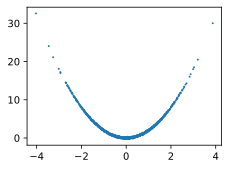

In [26]:
# 2.为电压和电流的关系建立模型。
def self_synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    # 均值为0，方差为1 的随机数
    X = torch.normal(0, 1, (num_examples,len(w)))
    y = w*X*X + b
    y += torch.normal(0, 0.1, y.shape)

    return X, y.reshape((-1, 1))

true_w = torch.tensor([2])
true_b = 0
features, labels = self_synthetic_data(true_w, true_b, 2000)
print(true_w,true_b,features.size,labels.size)

d2l.set_figsize()
d2l.plt.scatter(features.detach().numpy(), labels.detach().numpy(), 1)

def multi_log(X, w, b): #@save
    """多项式回归模型"""
    print(X.size,w.size,b.size,(X*X).size)
    
    return torch.matmul(X*X, w) + b

w = torch.normal(0, 0.00, size=(1,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 0.03
num_epochs = 3
net = multi_log
loss = squared_loss
batch_size=30
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        #print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

print(w,f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(b,f'b的估计误差: {true_b - b}')


# 3 线性模型的简洁实现
## 3.1 生成并读取数据集

In [27]:
from torch.utils import data

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[-1.2975,  1.1155],
         [ 0.6459, -0.2799],
         [ 1.0181,  0.9252],
         [-0.8095,  0.5884],
         [-2.0828, -0.0794],
         [ 0.3599, -0.3792],
         [-0.3420, -0.3455],
         [-0.8939,  0.6614],
         [-0.0056, -0.8284],
         [-0.6049,  1.8851]]),
 tensor([[-2.2010],
         [ 6.4217],
         [ 3.0899],
         [ 0.5954],
         [ 0.3264],
         [ 6.2264],
         [ 4.6977],
         [ 0.1659],
         [ 6.9951],
         [-3.4090]])]

## 3.2 定义模型

In [28]:
# nn是神经网络的缩写
from torch import nn

#在PyTorch中，全连接层在Linear类中定义
#第一个指定输入特征形状，即2，第二个指定输出特征形状，输出特征形状为单个标量，因此为1

net = nn.Sequential(nn.Linear(2, 1))

## 3.3 初始化模型参数
net[0]选择网络中的第一个图层

使用weight.data和bias.data方法访问参数

使用替换方法normal_和fill_来重写参数值

In [29]:
net[0].weight.data.normal_(0, 0.01)# 使用正态分布替代
net[0].bias.data.fill_(0)

tensor([0.])

## 3.4 定义损失函数
计算均方误差使用的是MSELoss类，也称为平方L2范数。 默认情况下，它返回所有样本损失的平均值。

In [30]:
loss = nn.MSELoss()

## 3.5 定义优化算法
小批量随机梯度下降

In [31]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

## 3.6 训练
回顾一下：在每个迭代周期里，我们将完整遍历一次数据集（train_data）， 不停地从中获取一个小批量的输入和相应的标签。 对于每一个小批量，我们会进行以下步骤:

* 通过调用net(X)生成预测并计算损失l（前向传播）。

* 通过进行反向传播来计算梯度。

* 通过调用优化器来更新模型参数。

为了更好的衡量训练效果，我们计算每个迭代周期后的损失，并打印它来监控训练过程。

In [32]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()# 梯度清零
        l.backward()
        trainer.step()# 模型更新
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

w = net[0].weight.data
print(w,'w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print(b,'b的估计误差：', true_b - b)
net[0].weight.grad,net[0].bias.grad


epoch 1, loss 0.000292
epoch 2, loss 0.000098
epoch 3, loss 0.000098
tensor([[ 1.9997, -3.3999]]) w的估计误差： tensor([ 0.0003, -0.0001])
tensor([4.1998]) b的估计误差： tensor([0.0002])


(tensor([[ 0.0038, -0.0017]]), tensor([0.0103]))

## 3.7 练习
1.如果将小批量的总损失替换为小批量损失的平均值，需要如何更改学习率？

lr/batch_size

2.如何访问线性回归的梯度？
net[0].weight.grad
net[0].bias.grad

# 4 Softmax回归
回归可以用于预测多少的问题

softmax运算获取一个向量并将其映射为概率。

softmax回归适用于分类问题，它使用了softmax运算中输出类别的概率分布。

交叉熵是一个衡量两个概率分布之间差异的很好的度量，它测量给定模型编码数据所需的比特数。

$y=softmax(o)$

其中，$y_i=\frac{exp(o_j)}{\sum_kexp(o_k)}$

## 4.1 小批量样本的矢量化
小批量样本特征为X，权重为W，偏置为b,softmax的矢量表达式为

$O=XW+b$

$Y=saofmax(O)$

X中的每一行是一个数据样本，那么softmax可以按行执行。对于O的每一行，我们先对所有项进行幂运算，然后求和对它们进行标准化。XW+b求和会使用广播机制，小批量的未规范化预测O和输出概率Y都是形状为n*q的矩阵。


## 4.2 损失函数
1. 均方损失（L2loss)
   
2. L1loss:$l(y,y^{'})=|y-y^{'}|$
   
3. 交叉熵
利用最大似然估计（交叉熵）来度量预测的结果:$P(Y|X)=\prod\limits_{i=0}^nP(y^{(i)}|x^{(i)})$

相当于最小化负对数似然：$-logP(Y|X)=\sum\limits_{i=1}^n-log(y^{(i)}|x^{(i)})=\sum\limits_{i=1}^nl(y^{(i)},\widehat{y}^{(i)})$，其中，$l(y,\widehat{y})=-\sum\limits_{j=1}^qy_jlog\widehat{y}_j$

梯度是观测值y和估计值$\widehat{y}$之间的差异

对于输出，不仅仅是一个结果，而是用一个概率向量表示

4. Huber's robust loss

$l(y,y^{'})=|y-y^{'}|-0.5 if |y-y^{'}|>1$

$l(y,y^{'})=0.5(y-y^{'})^2 otherwise$

当预测值和真实值相差较大时，是一个绝对值误差，否则是平方误差。

导数：当$|y-y^{'}|$大于1（当预测值和真实值相差较大）时，是一个常数，梯度以均匀的方式递减，在预测值和真实值靠近的时候，保证优化比较平滑。


## 4.3 信息论基础
熵

可以把交叉熵想象为“主观概率为Q的观察者在看到根据概率P生成的数据时的预期惊异”。

简而言之，我们可以从两方面来考虑交叉熵分类目标： （i）最大化观测数据的似然；（ii）最小化传达标签所需的惊异。


## 4.4 模型预测和评估
在训练softmax回归模型后，给出任何样本特征，我们可以预测每个输出类别的概率。 通常我们使用预测概率最高的类别作为输出类别。 如果预测与实际类别（标签）一致，则预测是正确的。 在接下来的实验中，我们将使用精度（accuracy）来评估模型的性能。 精度等于正确预测数与预测总数之间的比率。

# 5 图像分类数据集
Fashion-MNIST数据集

In [33]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

## 5.1 读取数据集
通过框架中的内置函数将Fashion-MNIST数据集下载并读取到内存中。
Fashion-MNIST由10个类别的图像组成， 每个类别由训练数据集（train dataset）中的6000张图像 和测试数据集（test dataset）中的1000张图像组成。 因此，训练集和测试集分别包含60000和10000张图像。 测试数据集不会用于训练，只用于评估模型性能。

In [34]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [35]:
# 训练集和测试集大小
len(mnist_train), len(mnist_test)

(60000, 10000)

In [36]:
# 每个输入图像的高度和宽度均为28像素。 数据集由灰度图像组成，其通道数为1。 
# 为了简洁起见，本书将高度h像素、宽度w像素图像的形状记为h*w或（h,w）。
mnist_train[0][0].shape

torch.Size([1, 28, 28])

Fashion-MNIST中包含的10个类别，分别为t-shirt（T恤）、trouser（裤子）、pullover（套衫）、dress（连衣裙）、coat（外套）、sandal（凉鞋）、shirt（衬衫）、sneaker（运动鞋）、bag（包）和ankle boot（短靴）。 以下函数用于在数字标签索引及其文本名称之间进行转换。

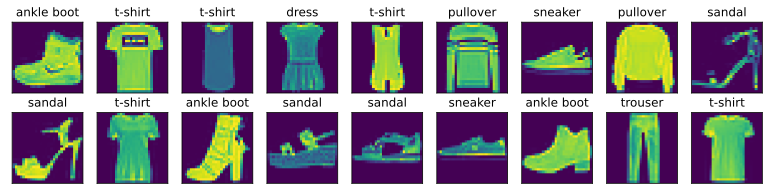

In [51]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


# 可视化
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

## 5.2 读取小批量

In [38]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())


timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'9.38 sec'

## 5.3 整合所有组件

In [39]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

下面，我们通过指定resize参数来测试load_data_fashion_mnist函数的图像大小调整功能。

In [40]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# 6 softmax回归的从零开始实现
## 6.1 读取数据集

In [91]:
import torch
from IPython import display
from d2l import torch as d2l
# 读取数据集
train_iter, test_iter = d2l.load_data_fashion_mnist(256)

## 6.2 初始化
 原始数据集中的每个样本都是28×28的图像。 本节将展平每个图像，把它们看作长度为784的向量,每个像素看作一个特征。
 输出维度为10.权重将构成一个784×10的矩阵， 偏置将构成一个的1×10行向量
 权重和偏置初始化为0

In [92]:
# 初始化
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 6.3 softmax操作
每一个样本是一行，对每个项求幂然后求和，每一行除以和，确保结果和为1

In [93]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

# 举个例子
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2075, 0.2442, 0.0994, 0.3304, 0.1184],
         [0.2946, 0.2423, 0.0531, 0.1035, 0.3065]]),
 tensor([1.0000, 1.0000]))

## 6.4 定义模型及损失函数

In [94]:
def net(X):
    # -1自动计算行数
    
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

# 标签
y = torch.tensor([0, 2])
# 预测结果
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
# 使用y作为y_hat中概率的索引， 我们选择第一个样本中第一个类的概率和第二个样本中第三个类的概率
y_hat[[0, 1], y],len(y_hat)


# 交叉熵损失函数
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## 6.5 分类精度
如果y_hat是一个矩阵，假设第二个维度存储每个类的预测分数。用argmax
来获得每行中最大元素的索引来获得预测类别。

然后我们将预测类别与真实y元素进行比较。 由于等式运算符“==”对数据类型很敏感， 因此我们将y_hat的数据类型转换为与y的数据类型一致。 结果是一个包含0（错）和1（对）的张量。 最后，我们求和会得到正确预测的数量。

In [95]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    print(y_hat)
    cmp = y_hat.type(y.dtype) == y
    print(cmp)
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)
y_hat,y

tensor([2, 2])
tensor([False,  True])


(tensor([[0.1000, 0.3000, 0.6000],
         [0.3000, 0.2000, 0.5000]]),
 tensor([0, 2]))

同样，对于任意数据迭代器data_iter可访问的数据集， 我们可以评估在任意模型net的精度。

In [96]:
#这里定义一个实用程序类Accumulator，用于对多个变量进行累加。
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

evaluate_accuracy(net, test_iter)

tensor([0, 0, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 5, 0, 0,
        4, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 5, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0, 0, 0, 0, 6, 4, 0, 5, 4, 0,
        0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 4, 5, 0, 5, 0, 0, 0, 4, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 7, 5, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0, 0,
        0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 4, 0,
        0, 0, 1, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 4, 0, 0, 4, 0,
        4, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, F

0.1161

## 6.6 训练
如何训练一个迭代周期

In [97]:

def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)# 在3个变量上累加
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数，自己从头开始实现
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())# 3个变量
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]


class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

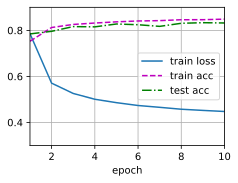

In [98]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

## 6.7 预测


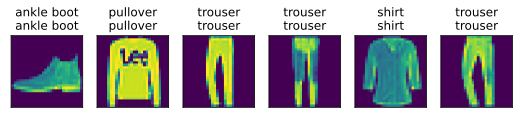

In [99]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# 7 softmax简洁实现
## 7.1 读取数据集

In [104]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 7.2 初始化模型参数
全连接层，输入784，输出10
以均值0和标准差0.01随机初始化权重

In [105]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

## 7.3 损失函数及softmax回归
在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数

In [106]:
loss = nn.CrossEntropyLoss(reduction='none')

## 7.4 优化算法
学习率为0.1的小批量随机梯度下降作为优化算法

In [107]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 7.5 训练

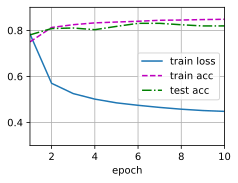

In [108]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)